In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [63]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import os
import numpy as np
import pandas as pd
import datetime
import os.path 
import sys  
import pyfolio as pf
import backtrader as bt
import backtrader.strategies as btstrats

sys.path.append('..')
from engine.bs_engine import get_stk_market_daily


In [3]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    
    params = (
            ('exitbars', 5),
            ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        # To keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        """订单状态检查函数"""
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        # Check if we are in the market
        if not self.position:
            if self.dataclose[0] > self.sma[0]:
                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size=10)

        else:
            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(size=10)
                
                

In [37]:
# Obtain BaoStock data with engine
market_info = get_stk_market_daily('000001.sz', datetime.datetime(2019, 1, 1), datetime.datetime(2020, 12, 31))
market_info = market_info.loc[:, ['date', 'code', 'open', 'high', 'low', 'close', 'preclose', 'volume', 'amount', 'turn']]
market_info['openinterest'] = 0
market_info.set_index('date', inplace=True)
market_info.index = pd.to_datetime(market_info.index, format='%Y-%m-%d')

In [38]:
market_info.tail()

,code,open,high,low,close,preclose,volume,amount,turn,openinterest
date,,,,,,,,,,
2020-12-25,000001.sz,18.26,18.26,17.8,18.04,18.26,5.77077e+07,1.03813e+09,0.2974,0
2020-12-28,000001.sz,18.02,18.86,17.96,18.85,18.04,1.27034e+08,2.35295e+09,0.6546,0
2020-12-29,000001.sz,18.87,19.3,18.7,19.17,18.85,9.63092e+07,1.83795e+09,0.4963,0
2020-12-30,000001.sz,19,19.2,18.72,19.2,19.17,9.78498e+07,1.85408e+09,0.5042,0
2020-12-31,000001.sz,19.21,19.58,19.02,19.34,19.2,9.24503e+07,1.78174e+09,0.4764,0


In [57]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

# Datas are in a subfolder of the samples. Need to find where the script is
# because it could have been called from anywhere

# Create a Data Feed
data = bt.feeds.PandasData(dataname=market_info,
                           fromdate=datetime.datetime(2019, 1, 1),
                           todate=datetime.datetime(2020, 12, 31))
                            
# Add the Data Feed to Cerebro
cerebro.adddata(data, name='000001.sz')

# Set our desired cash start
cerebro.broker.setcash(100000.0)
dcash0 = cerebro.broker.startingcash

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=100)

# Set the commission
cerebro.broker.setcommission(commission=0.001)

cerebro.addanalyzer(bt.analyzers.Returns, timeframe=bt.TimeFrame.Years, _name='Returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Years, _name='timeReturns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Months, _name='timeReturns')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='AnnualReturn')
cerebro.addanalyzer(bt.analyzers.SQN, _name='sqnAnz')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='SharpeRatio')
cerebro.addanalyzer(bt.analyzers.VWR, _name='VWR')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
results = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

dval9 = cerebro.broker.getvalue()
dget = dval9 - dcash0
kret = dget/dcash0 * 100

print('\t起始资金 Starting Portfolio Value: %.2f' % dcash0)
print('\t资产总值 Final Portfolio Value: %.2f' % dval9)
print('\t利润总额: %.2f' % dget)
print('\t ROI 投资回报率 Return On Investment: %.2f %%' % kret)

Starting Portfolio Value: 100000.00
2019-01-22, Close, 10.28
2019-01-22, BUY CREATE, 10.28
2019-01-23, BUY EXECUTED, Price: 10.29, Cost: 102.90, Comm 0.10
2019-01-23, Close, 10.35
2019-01-24, Close, 10.52
2019-01-25, Close, 11.00
2019-01-28, Close, 10.94
2019-01-29, Close, 11.00
2019-01-30, Close, 10.95
2019-01-31, Close, 11.10
2019-02-01, Close, 11.20
2019-02-11, Close, 11.21
2019-02-12, Close, 11.19
2019-02-13, Close, 11.38
2019-02-14, Close, 11.25
2019-02-15, Close, 10.95
2019-02-18, Close, 11.36
2019-02-19, Close, 11.27
2019-02-20, Close, 11.41
2019-02-21, Close, 11.36
2019-02-22, Close, 11.54
2019-02-25, Close, 12.55
2019-02-26, Close, 12.20
2019-02-27, Close, 12.40
2019-02-28, Close, 12.36
2019-03-01, Close, 12.76
2019-03-04, Close, 12.99
2019-03-05, Close, 13.06
2019-03-06, Close, 13.08
2019-03-07, Close, 12.74
2019-03-08, Close, 12.30
2019-03-11, Close, 12.32
2019-03-12, Close, 12.36
2019-03-12, SELL CREATE, 12.36
2019-03-13, SELL EXECUTED, Price: 12.34, Cost: 102.90, Comm 0.12

2020-07-31, Close, 13.34
2020-08-03, Close, 13.59
2020-08-04, Close, 14.04
2020-08-04, BUY CREATE, 14.04
2020-08-05, BUY EXECUTED, Price: 13.82, Cost: 138.20, Comm 0.14
2020-08-05, Close, 13.76
2020-08-05, SELL CREATE, 13.76
2020-08-06, SELL EXECUTED, Price: 13.82, Cost: 138.20, Comm 0.14
2020-08-06, OPERATION PROFIT, GROSS 0.00, NET -0.28
2020-08-06, Close, 13.90
2020-08-06, BUY CREATE, 13.90
2020-08-07, BUY EXECUTED, Price: 13.80, Cost: 138.00, Comm 0.14
2020-08-07, Close, 13.70
2020-08-07, SELL CREATE, 13.70
2020-08-10, SELL EXECUTED, Price: 13.67, Cost: 138.00, Comm 0.14
2020-08-10, OPERATION PROFIT, GROSS -1.30, NET -1.57
2020-08-10, Close, 13.95
2020-08-10, BUY CREATE, 13.95
2020-08-11, BUY EXECUTED, Price: 13.97, Cost: 139.70, Comm 0.14
2020-08-11, Close, 14.13
2020-08-12, Close, 14.38
2020-08-13, Close, 14.18
2020-08-14, Close, 14.47
2020-08-17, Close, 15.19
2020-08-18, Close, 15.15
2020-08-19, Close, 15.10
2020-08-20, Close, 14.59
2020-08-21, Close, 14.45
2020-08-24, Close, 14


#8

#8-1,基本BT量化分析数据
	夏普指数 SharpeRatio:  -935.9576064135903
	最大回撤周期 max_drawdown_len:  176
	最大回撤 max_drawdown:  0.025713647048475716
	最大回撤（资金） max_drawdown_money:  25.722500000018044

#8-2,常用量化分析数据
	SQN指数、AnnualReturn 年化收益率、Trade 交易分析报告
	可以修改指数，改为其他时间周期：周、月、季度等
Returns:
  - rtot: 0.0005068765163910461
  - ravg: 0.00025343825819552305
  - rnorm: 0.00025347037638415024
  - rnorm100: 0.025347037638415025
TimeReturn:
  - 2019-12-31: 0.00024305700000026853
  - 2020-12-31: 0.00026388386117992546
TimeReturn:
  - 2019-01-31 00:00:00: 7.997100000012303e-05
  - 2019-02-28 00:00:00: 0.00012598992445989055
  - 2019-03-31 00:00:00: -5.7754104329399425e-05
  - 2019-04-30 00:00:00: 8.89148223788272e-05
  - 2019-05-31 00:00:00: -8.2758375258285e-05
  - 2019-06-30 00:00:00: 0.00014274396675517664
  - 2019-07-31 00:00:00: -4.429783818205024e-05
  - 2019-08-31 00:00:00: -8.41087364702453e-05
  - 2019-09-30 00:00:00: 1.2607873303815964e-05
  - 2019-10-31 00:00:00: 3.567453256403397e-05
  - 2019-11-30 00:0

<IPython.core.display.Javascript object>


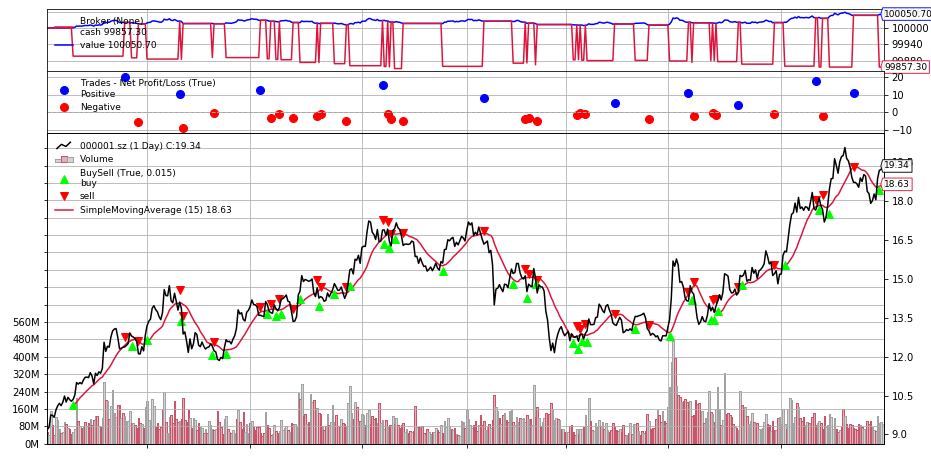


zok


In [58]:
print('\n#8')
strat = results[0]
anzs = strat.analyzers
dsharpe = anzs.SharpeRatio.get_analysis()['sharperatio']
dw = anzs.DW.get_analysis()
max_drawdown_len = dw['max']['len']
max_drawdown = dw['max']['drawdown']
max_drawdown_money = dw['max']['moneydown']

print('\n#8-1,基本BT量化分析数据')
print('\t夏普指数 SharpeRatio: ', dsharpe)
print('\t最大回撤周期 max_drawdown_len: ', max_drawdown_len)
print('\t最大回撤 max_drawdown: ', max_drawdown)
print('\t最大回撤（资金） max_drawdown_money: ', max_drawdown_money)

print('\n#8-2,常用量化分析数据')
print('\tSQN指数、AnnualReturn 年化收益率、Trade 交易分析报告')
print('\t可以修改指数，改为其他时间周期：周、月、季度等')
for alyzer in strat.analyzers:
    alyzer.print()
    
print('\n#9,绘制BT量化分析图形')
cerebro.plot()

print('\nzok')

In [68]:
cerebro = bt.Cerebro()

# data
data = bt.feeds.PandasData(dataname=market_info,
                           fromdate=datetime.datetime(2019, 1, 1),
                           todate=datetime.datetime(2020, 12, 31))

cerebro.adddata(data)

# strategy
cerebro.addstrategy(btstrats.SMA_CrossOver)

# Analyzer
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

thestrats = cerebro.run()
thestrat = thestrats[0]
anzs = thestrat.analyzers

print('Sharpe Ratio:', anzs.mysharpe.get_analysis())

xpyf = anzs.getbyname('pyfolio')
xret, xpos, xtran, gross_lev = xpyf.get_pf_items()
xret = pf.utils.to_utc(xret)
xpos = pf.utils.to_utc(xpos)
xtran = pf.utils.to_utc(xtran)

pf.create_full_tear_sheet(xret,
                          positions=xpos,
                          transactions=xtran,
                          benchmark_rets=xret
                         )

# cerebro.plot()

Sharpe Ratio: OrderedDict([('sharperatio', -37.034510756279595)])


Start date,2019-01-02
End date,2020-12-31
Total months,23
,Backtest
Annual return,0.0%
Cumulative returns,0.0%
Annual volatility,0.0%
Sharpe ratio,0.06
Calmar ratio,0.03
Stability,0.07
Max drawdown,-0.1%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'

In [55]:
market_info.index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='date', length=487, freq=None)